# 스페이스 타이타닉

In [1]:
from IPython.display import Image
  
# 이미지 넣기
Image(url="https://img5.goodfon.ru/original/1920x1080/9/11/planeta-spacecrafts-art-planet-fantastika-kosmicheskii-korab.jpg")


---

*2912년, 우주선 '타이타닉'에서 조난신호가 도착했다.*  
*우주 먼지 구름에 충돌한 타이타닉은 13000명의 승객들 중 절반이 다른 차원으로 전송되어 버렸다.*  
*실종자들을 구출하기 위해선 어떤 승객이 전송되었는지 예측해야된다...*  

---

---

### [1] 데이터 불러오기


---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# 훈련 데이터 불러오기
train = pd.read_csv('./data/train01.csv')
test = pd.read_csv('./data/test01.csv')

In [4]:
# 데이터 살펴보기
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,4,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,S,1,0,0,0,0,0,0,4,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,S,1,0,0,0,0,0,0,7,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,S,1,0,0,0,0,0,0,7,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,S,1,0,0,0,0,0,0,9,True


In [5]:
# 데이터 모양 살펴보기
train.shape

(8693, 24)

In [6]:
# 결측치 확인하기
train.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Expenditure      0
No_spending      0
Solo             0
Cabin_deck       0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
Transported      0
dtype: int64

In [7]:
# 컬럼별 요소 수
train.nunique()

HomePlanet          3
CryoSleep           2
Destination         3
Age                83
VIP                 2
RoomService      1296
FoodCourt        1531
ShoppingMall     1136
Spa              1352
VRDeck           1330
Expenditure      2627
No_spending         2
Solo                2
Cabin_deck          8
Cabin_side          3
Cabin_region1       2
Cabin_region2       2
Cabin_region3       2
Cabin_region4       2
Cabin_region5       2
Cabin_region6       2
Cabin_region7       2
Family_size        20
Transported         2
dtype: int64

In [8]:
# 데이터 타입 확인
train.dtypes

HomePlanet        object
CryoSleep           bool
Destination       object
Age              float64
VIP                 bool
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Expenditure      float64
No_spending        int64
Solo               int64
Cabin_deck        object
Cabin_side        object
Cabin_region1      int64
Cabin_region2      int64
Cabin_region3      int64
Cabin_region4      int64
Cabin_region5      int64
Cabin_region6      int64
Cabin_region7      int64
Family_size        int64
Transported         bool
dtype: object

---

### [2] EDA

---

**target 비중 확인**

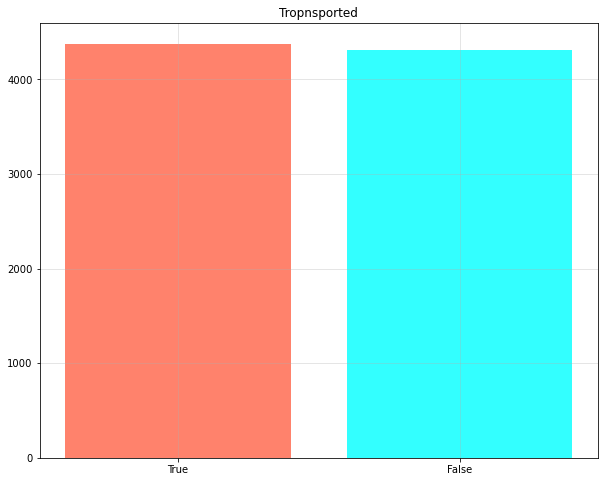

In [9]:
# 타겟 비중에 대한 bar 그래프 시각화
plt.figure(figsize = (10,8))
plt.bar(['True', 'False'], train['Transported'].value_counts(), color = ['tomato', 'cyan'], alpha = .8)
plt.title('Tropnsported')
plt.grid(True, alpha = 0.4)

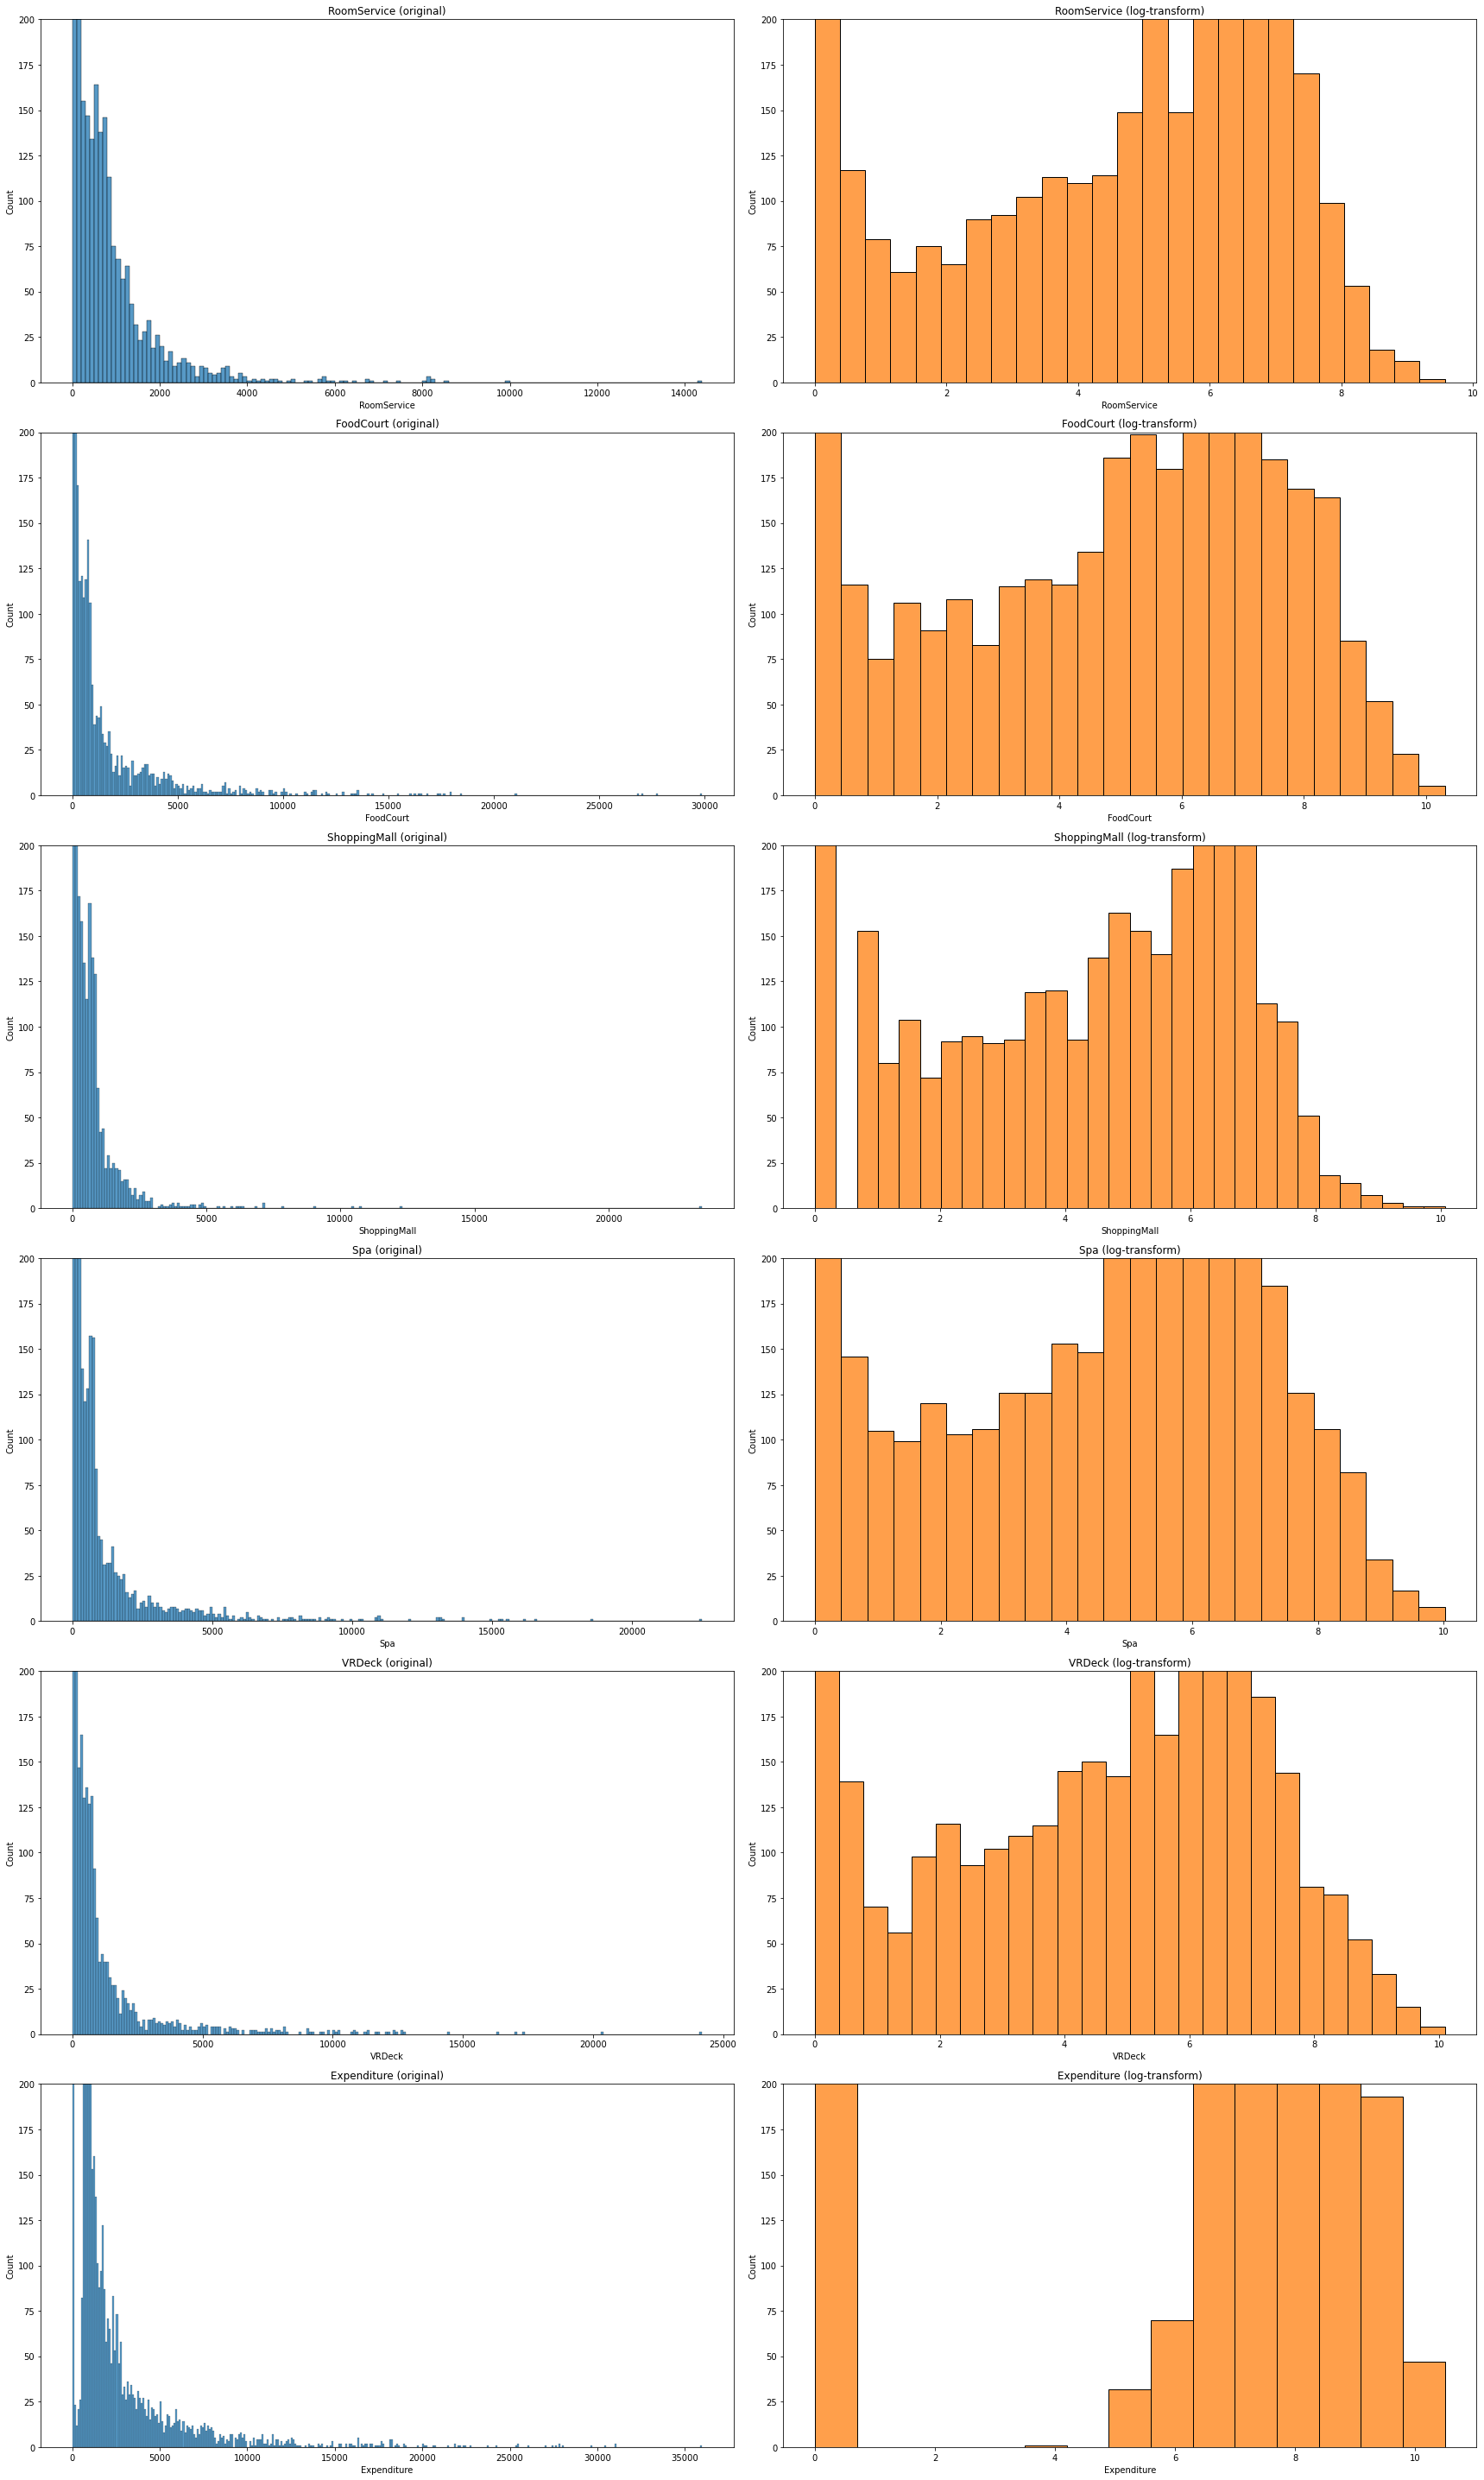

In [10]:
# Plot log transform results
fig=plt.figure(figsize=(24,40))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(train[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+train[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

이상치가 지나치게 극단적임으로 알고리즘의 성능을 위해 연속형 특성들의 값들을 log로 계산

In [11]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    train[col]=np.log(1+train[col])
    test[col]=np.log(1+test[col])

In [12]:
input = train.iloc[:,:-1]
target = train.iloc[:,[-1]]

각 컬럼별 인코딩 및 정규화

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
# 컬럼의 값이 연속형인지 범주형인지 구분
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train.columns if train[cname].dtype == "object"]

In [15]:
# 연속형 컬럼의 경우 정규분포로 정규화
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [16]:
# 범주형 컬럼의 경우 원-핫-인코딩으로 숫자형으로 변경
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

In [17]:
# 전처리 방식을 통합
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

In [18]:
# 전처리 적용
input = ct.fit_transform(input)
test = ct.fit_transform(test)

In [19]:
from sklearn.model_selection import train_test_split

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    input, target,
    stratify=target, # 타겟 비중 유지
    test_size=0.2, # 크기 설정
    random_state=42
    )

---

### [3] 모델 선정

---

In [20]:
from sklearn.utils import all_estimators
import warnings
warnings.filterwarnings('ignore')

all_algorithms = all_estimators(type_filter='classifier')

list_name_model = []
list_train_score = []
list_test_score = []


for (name, algorithm) in all_algorithms:
    try :
        clf = algorithm()
        clf.fit(train_input, train_target)

        train_score = 0
        test_score = 0

        train_score = round(clf.score(train_input,train_target), 3)
        test_score = round(clf.score(test_input,test_target), 3)

        if list_train_score != 0 and list_test_score != 0 :
            list_train_score.append(train_score)
            list_test_score.append(test_score)
            list_name_model.append(name)
    except :
        continue

In [110]:
df_model = pd.DataFrame([list_name_model, list_train_score, list_test_score]).T
df_model.columns = ['모델', '훈련 점수', '테스트 점수']

In [117]:
df_model01 = df_model
df_model01['과대적합도'] = df_model['훈련 점수'] - df_model['테스트 점수'] 

In [150]:
df_model02 = df_model
for i in range(0, len(df_model)) :
    if df_model02['훈련 점수'][i] > df_model02['테스트 점수'][i] :
        df_model02 = df_model02.drop(i)
df_model02 = df_model02.sort_values('테스트 점수')

KeyError: 1

In [137]:
df_model01 = df_model01[df_model01['과대적합도'] > 0]
df_model01 = df_model01.sort_values('과대적합도')

Text(0.5, 1.0, 'overpitting')

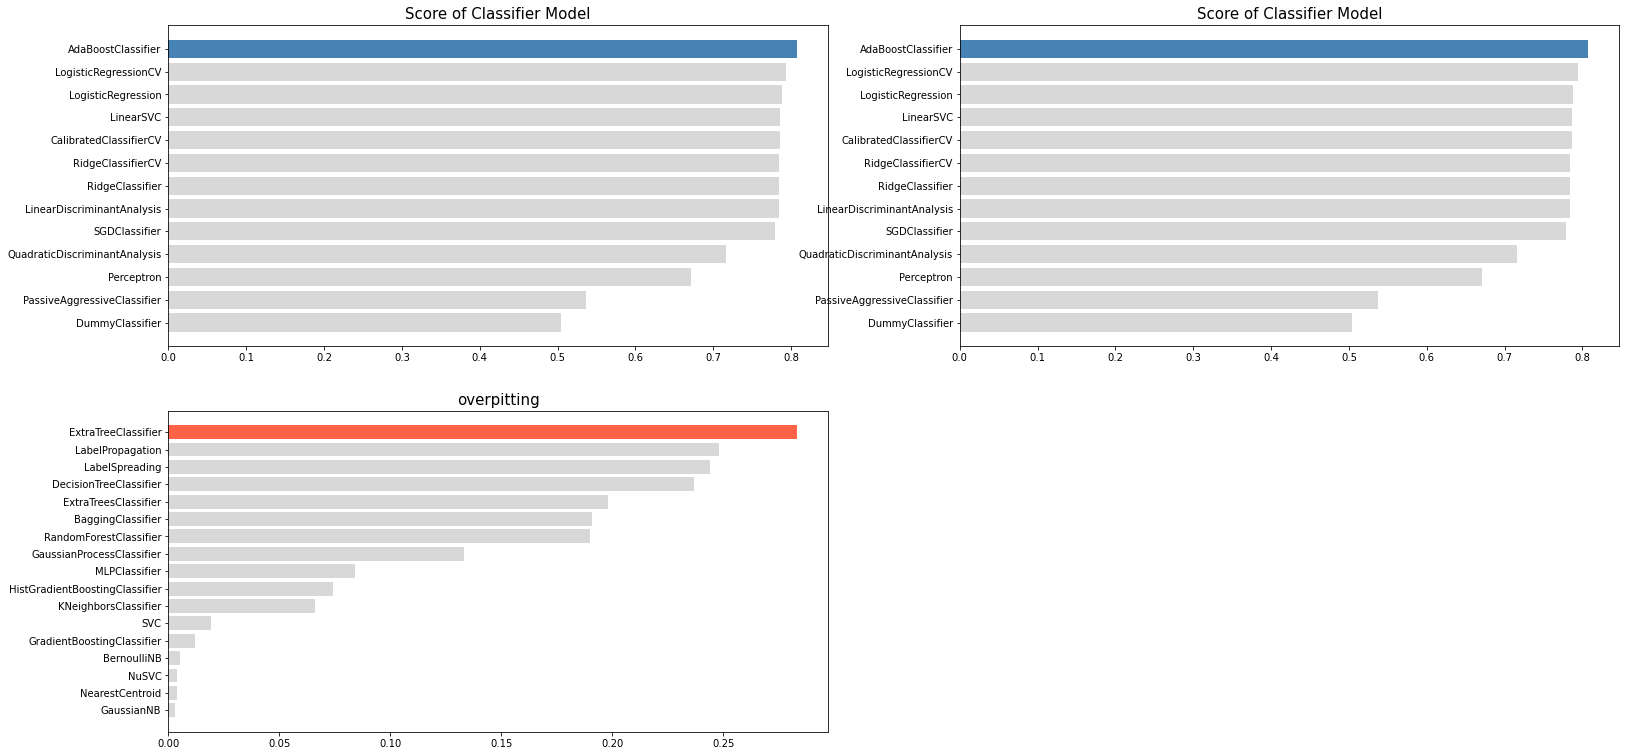

In [154]:
plt.figure(figsize=(26,13))

plt.subplot(2,2,1)
plt.barh(df_model['모델'], df_model['테스트 점수'], color = 'grey', alpha = .3)
plt.barh(df_model['모델'].iloc[-1], df_model['테스트 점수'].iloc[-1], color = 'steelblue') 
plt.title('Score of Classifier Model', fontdict = {'fontsize' : 15})

plt.subplot(2,2,2)
plt.barh(df_model['모델'], df_model['테스트 점수'], color = 'grey', alpha = .3)
plt.barh(df_model['모델'].iloc[-1], df_model['테스트 점수'].iloc[-1], color = 'steelblue') 
plt.title('Score of Classifier Model', fontdict = {'fontsize' : 15})

plt.subplot(2,2,3)
plt.barh(df_model01['모델'], df_model01['과대적합도'], color = 'grey', alpha = .3)
plt.barh(df_model01['모델'].iloc[-1], df_model01['과대적합도'].iloc[-1], color = 'tomato')
plt.title('overpitting', fontdict = {'fontsize' : 15})

전체 분류 모델에서 아무런 파라미터를 설정하지 않은 채  
훈련 점수보다 테스트 점수가 높은 경우, 그 중에서 테스트 점수가 높은 AdaBoostClassifier이며  
전체 모델에서 과대 적합이 가장 높음 모델은 

---

#### **교차검증(계층별 k-겹 교차 검증)**

In [141]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble  import ExtraTreesClassifier

In [142]:
modelAda = AdaBoostClassifier()
modelExT = ExtraTreesClassifier()

In [143]:
# 각각 5겹 교차 검증을 통해 점수 계산
scores_Ada = cross_val_score(modelAda, train_input, train_target, cv = 5)
scores_ExT = cross_val_score(modelExT, train_input, train_target, cv = 5)

Text(0.5, 1.0, 'Cross variation Score of Classifier Model')

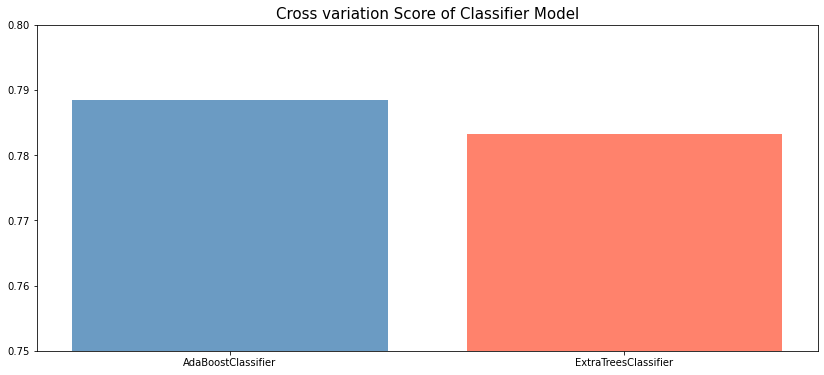

In [149]:
plt.figure(figsize=(14,6))
plt.bar(['AdaBoostClassifier', 'ExtraTreesClassifier'], [scores_Ada.mean(),scores_ExT.mean()], color=('steelblue', 'tomato'), alpha = .8)
plt.ylim(0.75, 0.8)
plt.title('Cross variation Score of Classifier Model', fontdict = {'fontsize' : 15})

교차 검증을 해보니 ExtraTreesClassifier보단 앙상블 모델인 AdaBoostClassifier가 교차 점수가 높은 걸 볼 수 있다  

ExtraTreesClassifier모델의 하이퍼 파라미터를 조절해서 과대적합을 해결하고 예측도를 높여보자

---

하이퍼파라미터  
penalty 를 l2, l1, elasticnet으로 올리면서   
c는 10, 5, 1, 0.1, 0.01 순으로  
max_iter 100, 500 순으로 조절해보자

---

In [48]:
# 성능 지표 확인 함수

In [65]:
list_c = [10, 5, 1, 0.1, 0.01]
list_max_iter = [100, 500, 1000, 1500, 2000]

In [83]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

list_parameter = []
list_acc = []
list_f1 = []
list_recall = []
list_precision = []

for j in range(0, len(list_c)) :
    for i in range(0, len(list_max_iter)):
        model = LogisticRegression(
            C = list_c[j],
            max_iter = list_max_iter[i]
        )
            
        model.fit(train_input, train_target)

        pred_train = model.predict(train_input)

        acc = accuracy_score(train_target, pred_train)
        f1 = f1_score(train_target, pred_train)
        recall = recall_score(train_target, pred_train)
        precision = precision_score(train_target, pred_train)

        parameter = (f"{list_c[j]}-{list_max_iter[i]}")

        list_parameter.append(parameter)
        list_acc.append(acc)
        list_f1.append(f1)
        list_recall.append(recall)
        list_precision.append(precision)


In [89]:
df_merics = pd.DataFrame([list_parameter, list_acc, list_f1, list_recall, list_precision]).T
df_merics.columns = ['parameter','acc', 'f1',' recal', 'precision']

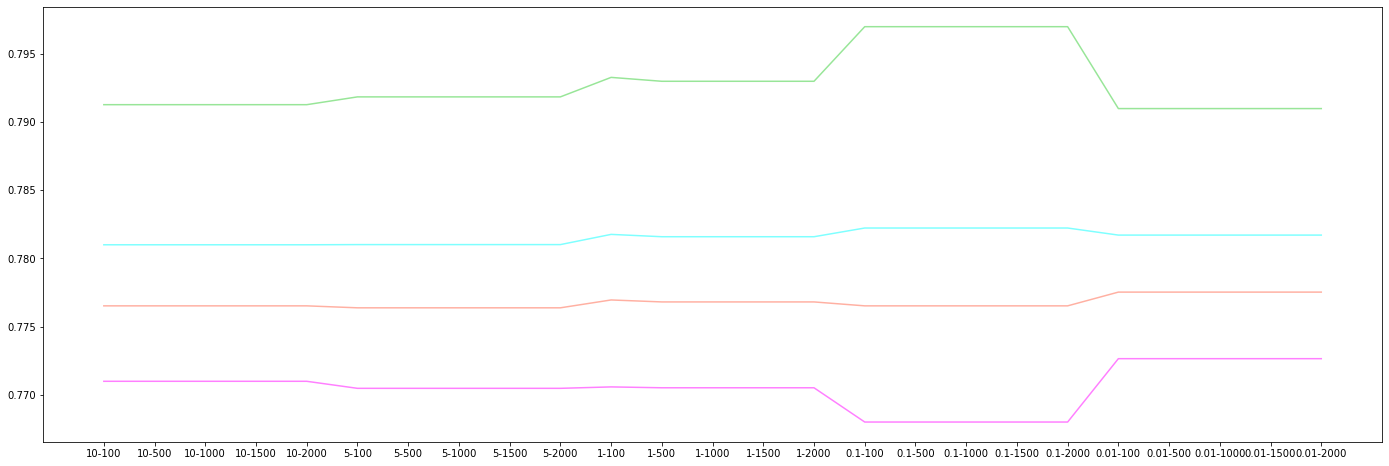

In [104]:
plt.figure(figsize=(24,8))

plt.plot(df_merics.iloc[:,0], df_merics.iloc[:,1], color = 'tomato', alpha =.5)
plt.plot(df_merics.iloc[:,0], df_merics.iloc[:,2], color = 'cyan', alpha = .5)
plt.plot(df_merics.iloc[:,0], df_merics.iloc[:,3], color = 'limegreen', alpha = .5)
plt.plot(df_merics.iloc[:,0], df_merics.iloc[:,4], color = 'magenta', alpha = .5)


In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

model_mm = LogisticRegressionCV()

params = {'penalty':['l2', 'l1'],
         'max_iter' : [100, 500, 1000, 1500, 2000]}

grid_clf = GridSearchCV(model_mm, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(train_input, train_target)
print('최적 하이퍼 파라미터 :{0}, 최적 평균 정확도 :{1:.3f}'.format(grid_clf.best_params_,
                                                   grid_clf.best_score_))

최적 하이퍼 파라미터 :{'max_iter': 100, 'penalty': 'l2'}, 최적 평균 정확도 :0.773
